In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

/Users/arifhussain/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("Online Retail.csv")

### Data Notes
- Dataset containing information on 4400 unique customers and their purchasing data
- InvoiceDate is object type (includes timestamp)
- CustomerID has many null values 
- No revenue column (can create; Quantity * UnitPrice) 
- Need to remove outliers and negative values from Quantity / UnitPrice
- Country variable is object type, will need to be converted to dummy
- StockCode variable is object type and needs to be converted via binary encoding. We will use binary encoding here to avoid extremely high dimensionality as there are too many unique values (4000+) to use the standard dummy approach here. 

In [3]:
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [4]:
print(df.info(), '\n', '\n', df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None 
 
 InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64


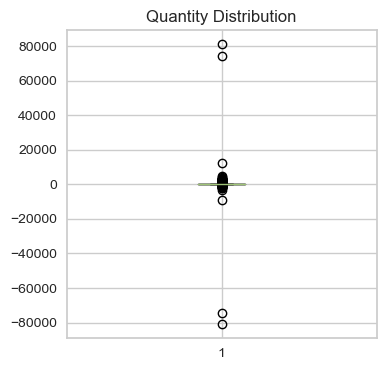

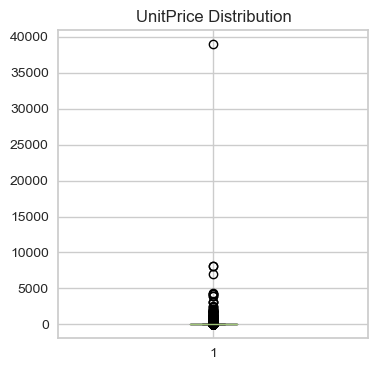

In [5]:
#Remove null values
df = df.dropna()

#Review distribution of Quantity and UnitPrice to identify any outliers. Use Boxplot for ease of visualization
distcolumns = ['Quantity', 'UnitPrice']

for col in distcolumns:
    plt.figure(figsize = (4,4))
    plt.boxplot(df[col])
    plt.title(col + ' Distribution')
    plt.show()

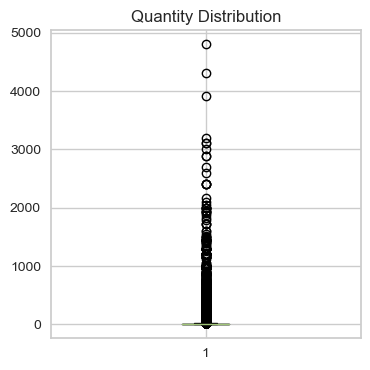

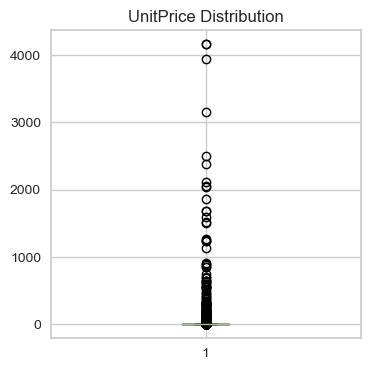

In [6]:
#Removing outliers + negative values
df = df[(df['UnitPrice'] > 0) & (df['UnitPrice'] < 6000)]
df = df[(df['Quantity'] > 0) & (df['Quantity'] < 60000)]

#Replot distribution to see if anything missed
for col in distcolumns:
    plt.figure(figsize = (4,4))
    plt.boxplot(df[col])
    plt.title(col + ' Distribution')
    plt.show()

In [7]:
#Create a new feature: Revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']

#Convert country to dummy variables (one-hot encoding)
country_dummies = pd.get_dummies(df['Country'], prefix = 'country')

#Merging with original df
df = pd.concat([df, country_dummies], axis=1)

#Modifying the date column to extract important features such as day, week, etc. 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['day_of_week'] = df['InvoiceDate'].dt.dayofweek
df['day_of_month'] = df['InvoiceDate'].dt.day
df['month'] = df['InvoiceDate'].dt.month
df['quarter'] = df['InvoiceDate'].dt.quarter
df['year'] = df['InvoiceDate'].dt.year

#Apply encoding method to StockCode in order to convert it into numerical value
encoder = ce.BinaryEncoder(cols = ['StockCode'])
df_encoded = encoder.fit_transform(df)

#Dropping the unnecessary columns no longer needed
df_encoded = df_encoded.drop(columns = ['Country', 'Quantity', 'UnitPrice', 'Description', 'CustomerID', 'InvoiceNo', 'InvoiceDate'])

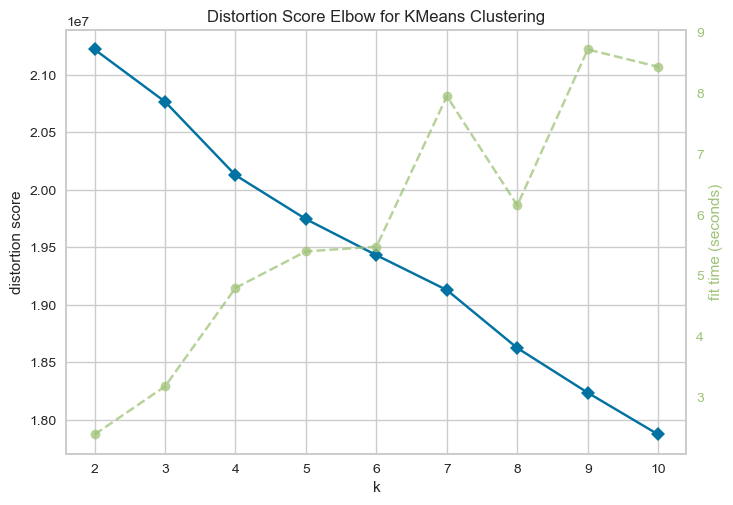

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
#Now let's use the elbow method to determine the optimal number of clusters for K Means
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)

Elbow = KElbowVisualizer(KMeans(), k=10)
Elbow.fit(scaled_data)
Elbow.show()

In [9]:
#There are too many features for us to properly run a Silhouette Score comparison for GMM. 
#Let's simplify the model via PCA (dimensionality reduction) before proceeding.

#Let's reduce our dimensionality to 3 as this will be easier to visualize + should help us with 
#saving on computational time as well
pca = PCA(n_components = 3)
reduced_data = pca.fit_transform(scaled_data)
pca_data = pd.DataFrame(reduced_data, columns=(['Component 1', 'Component 2', 'Component 3']))
pca_data.head()

,Component 1,Component 2,Component 3
0,-2.918543,0.159168,2.474972
1,-2.863858,0.173135,2.666280
2,-2.882653,0.168948,2.715069
3,-2.878520,0.215711,2.459955
4,-2.897839,0.210098,2.508161


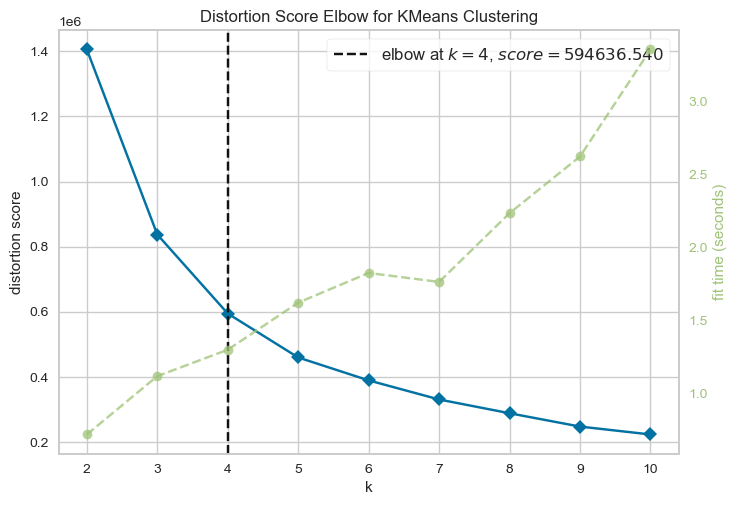

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
Elbow = KElbowVisualizer(KMeans(), k=10)
Elbow.fit(reduced_data)
Elbow.show()

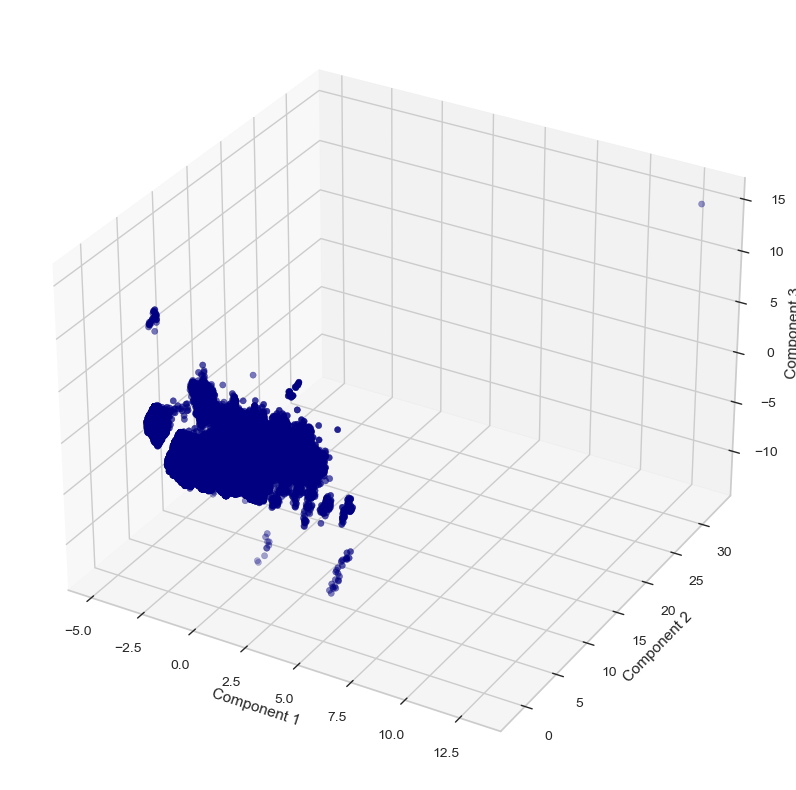

In [11]:
optimal_clusters = 4

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

x = pca_data['Component 1']
y = pca_data['Component 2']
z = pca_data['Component 3']

ax.scatter(x, y, z, c='navy', marker = 'o')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()

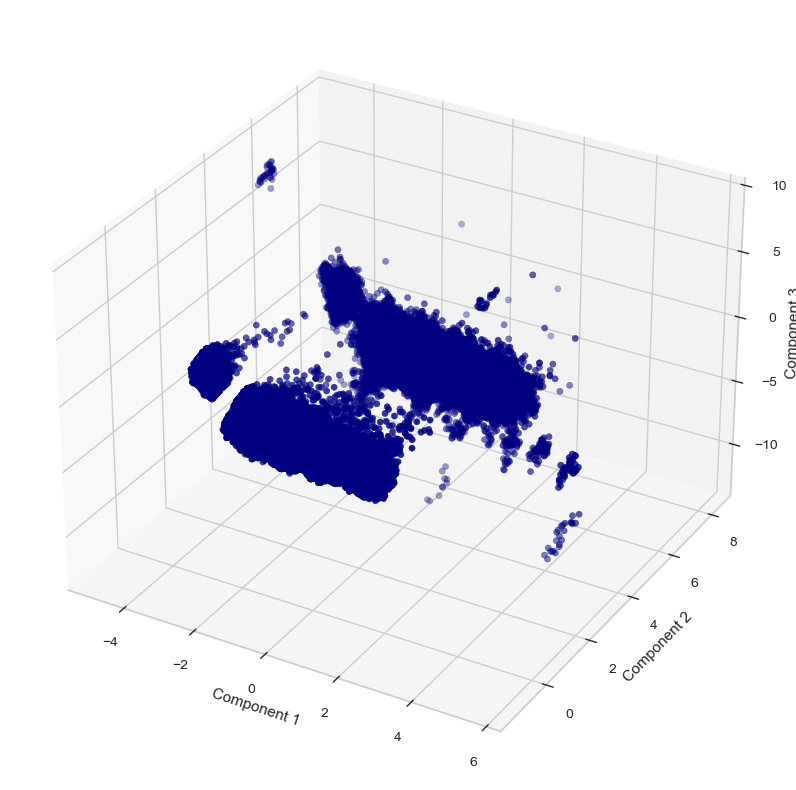

In [12]:
#Remove outlier (component 3)
filtered_pca_data = pca_data[pca_data['Component 3'] < 10]

#Extracting index (useful for later step)
filtered_index = filtered_pca_data.index

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

x = filtered_pca_data['Component 1']
y = filtered_pca_data['Component 2']
z = filtered_pca_data['Component 3']

ax.scatter(x, y, z, c='navy', marker = 'o')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()

In [13]:
kmeans = KMeans(n_clusters = optimal_clusters, random_state = 42)
kmeans.fit(filtered_pca_data)
cluster_labels = kmeans.labels_

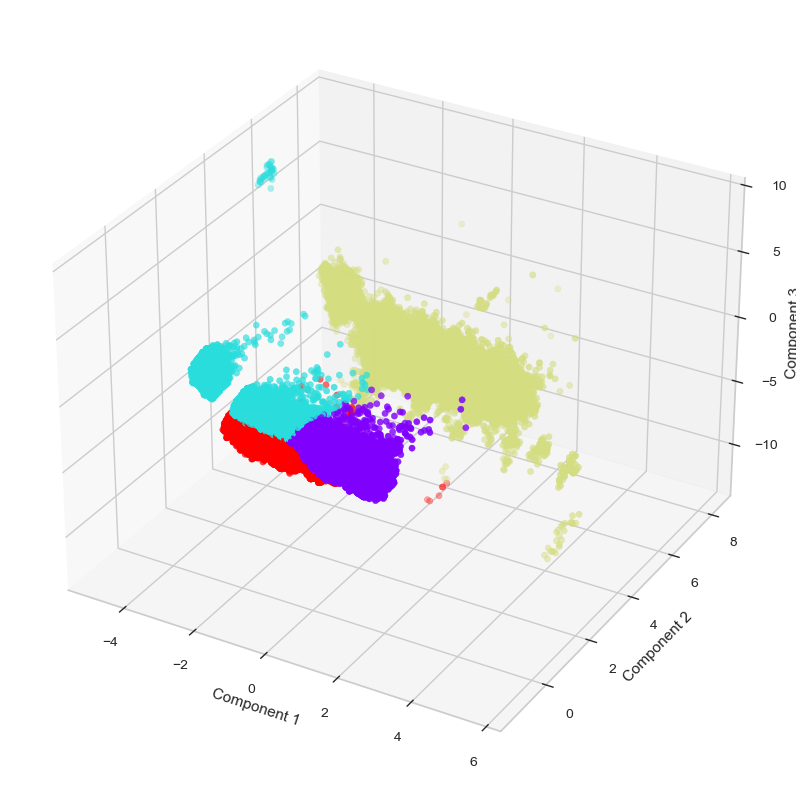

In [14]:
#Add labels for cluster values
filtered_pca_data['Cluster'] = cluster_labels

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

x = filtered_pca_data['Component 1']
y = filtered_pca_data['Component 2']
z = filtered_pca_data['Component 3']

ax.scatter(x, y, z, c=filtered_pca_data['Cluster'], marker = 'o', cmap='rainbow')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()

In [15]:
#Adding the cluster values back to the data
cluster_labels_series = pd.Series(cluster_labels, index=filtered_pca_data.index)
df['Cluster'] = cluster_labels_series
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Revenue  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34   

   country_Australia  ...  country_USA  country_United Arab Emirates  \
0                  0  ...            0                  

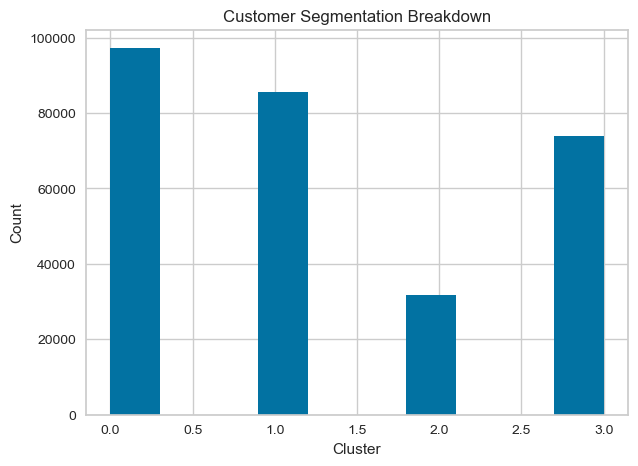

In [16]:
#Review clusters distribution
plt.figure(figsize = (7,5))
df['Cluster'].hist()
plt.title('Customer Segmentation Breakdown')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

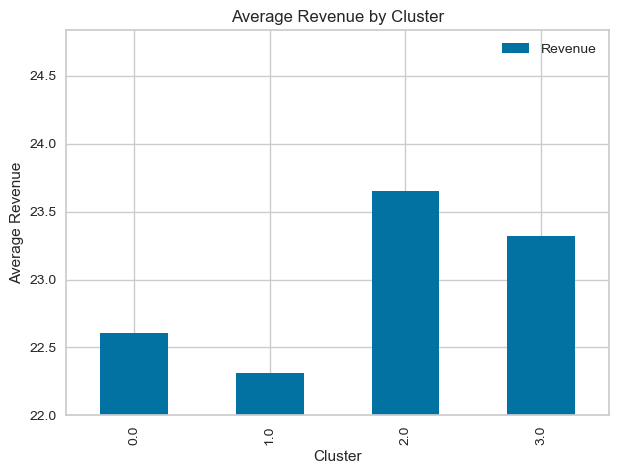

In [17]:
#Review average revenue per cluster
fig, ax = plt.subplots(figsize = (7,5))
df.groupby('Cluster')['Revenue'].agg('mean').reset_index().plot(kind='bar', x='Cluster', y='Revenue', ax=ax)
ax.set_xlabel('Cluster')
ax.set_ylabel('Average Revenue')
ax.set_title('Average Revenue by Cluster')
ax.set_ylim(22)
plt.show()

In [18]:
#Run GMM on data
gmm = GaussianMixture(n_components = optimal_clusters, covariance_type = 'full', random_state = 42)
gmm.fit(filtered_pca_data)

gmm_cluster_labels = gmm.predict(filtered_pca_data)

filtered_pca_data['GMM_Cluster'] = gmm_cluster_labels

NameError: name 'norm' is not defined

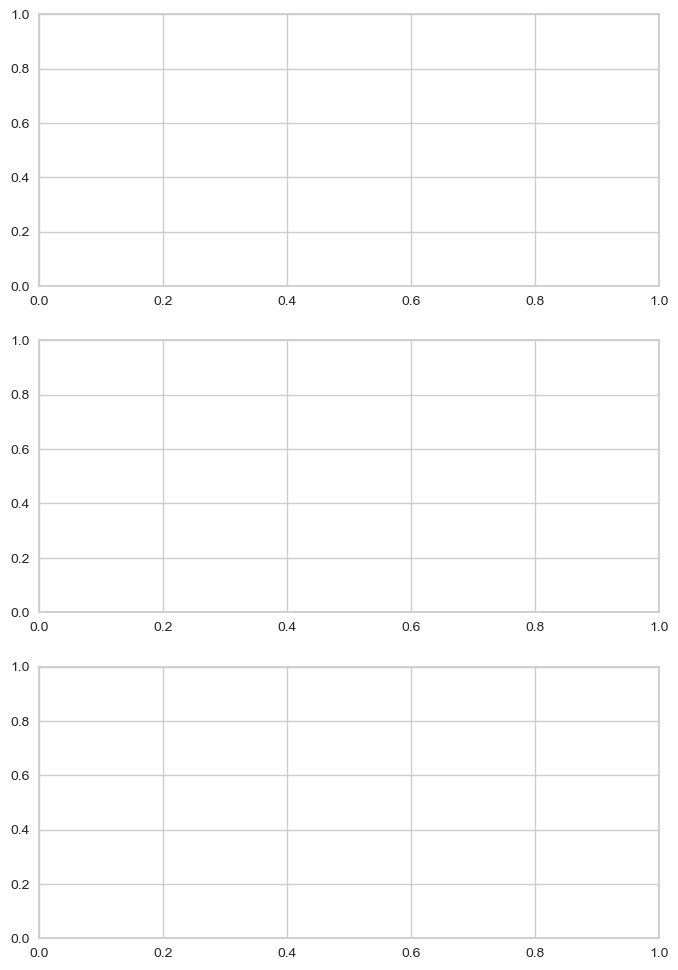

In [20]:
#Visualize the Gaussian Distribution of these clusters
gaussian_means = gmm.means_
gaussian_covariances = gmm.covariances_
gaussian_weights = gmm.weights_

#Create a range of values for the x-axis (adjust the range to fit your data)
x_values = np.linspace(-10, 10, 1000)

#Define the colors for the blue-navy theme
colors = ['#1f77b4', '#2c9ed4', '#3cbee4', '#4dddf4', '#5e9ced', '#6e5ad6']

#Plot the PDFs of the Gaussian components for each dimension
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

for dim in range(3):
    for idx, (mean, cov, weight) in enumerate(zip(gaussian_means, gaussian_covariances, gaussian_weights)):
        pdf = weight * norm.pdf(x_values, mean[dim], np.sqrt(cov[dim, dim]))
        axs[dim].plot(x_values, pdf, color=colors[idx % len(colors)], label=f'Cluster {idx}')
        axs[dim].fill_between(x_values, pdf, color=colors[idx % len(colors)], alpha=0.1)
    axs[dim].set_title(f'Component {dim+1}')
    axs[dim].set_xlabel('Value')
    axs[dim].set_ylabel('Probability Density')
    axs[dim].legend()

plt.tight_layout()
plt.show()

In [ ]:
#Visualize the GMM clusters 
#Define the colors for the blue-navy theme
colors = ['#1f77b4', '#2c9ed4', '#3cbee4', '#4dddf4', '#5e9ced', '#6e5ad6']

#Create a custom colormap using the blue-navy colors
blue_navy_cmap = ListedColormap(colors)

#Visualize the GMM clusters
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = filtered_pca_data['Component 1']
y = filtered_pca_data['Component 2']
z = filtered_pca_data['Component 3']

ax.scatter(x, y, z, c=filtered_pca_data['GMM_Cluster'], marker='o', cmap=blue_navy_cmap)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()

In [ ]:
#Adding clusters to original DF
gmm_cluster_labels_series = pd.Series(gmm_cluster_labels, index=filtered_pca_data.index)
df['GMM_Cluster'] = gmm_cluster_labels_series
print(df.head())

In [ ]:
#Review clusters distribution
plt.figure(figsize = (7,5))
df['GMM_Cluster'].hist(color = 'navy')
plt.title('Customer Segmentation Breakdown')
plt.xlabel('GMM Cluster')
plt.ylabel('Count')
plt.show()

In [ ]:
#Review average revenue per GMM cluster 
fig, ax = plt.subplots(figsize = (7,5))
df.groupby('GMM_Cluster')['Revenue'].agg('mean').reset_index().plot(kind='bar', x='GMM_Cluster', y='Revenue', ax=ax, color = 'navy')
ax.set_xlabel('GMM Cluster')
ax.set_ylabel('Average Revenue')
ax.set_title('Average Revenue by Cluster')
ax.set_ylim(22)
plt.show()